In [ ]:
#Utilities
from tqdm import tqdm
tqdm.pandas()

#Download resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP
from nltk import sent_tokenize, word_tokenize, RegexpParser
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import mark_negation

import nltk

nltk.download("punkt")
nltk.download("vader_lexicon")

PATH = "/content/drive/My Drive/Classroom/RADS 611/"

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df = pd.read_csv(PATH+"honest_doc_full.csv")

Visualize

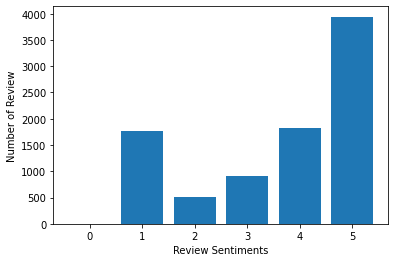

In [ ]:
Sentiment_count=df.groupby('score').count()
plt.bar(Sentiment_count.index.values, Sentiment_count['comment'])
plt.xlabel('Review Sentiments')
plt.ylabel('Number of Review')
plt.show()

## Cleaning the text

In [ ]:
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [ ]:
data_clean = pd.DataFrame(df.en.apply(round1))
data_clean

,en
0,overall it is considered good great service nu...
1,looks very good fast action the cost is reason...
2,been to this hospital many times can be both ...
3,intends to give birth naturally and buy a natu...
4,taking good care since walking into the door t...
...,...
8936,fast very clean the nurses are friendly better...
8937,good service polite words arrange things quick...
8938,arrange things quickly go to wait in line wait...
8939,the doctor took very good care the hospital is...


In [ ]:
#Using SpaCy to clean Stop Words and use Lemmatization
import spacy 
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS
import string
punct = string.punctuation
def clean_text_round2(text):
  cleaned_token = []
  doc = nlp(text)
  
  for word in doc:
    if word.lemma_ not in STOP_WORDS and word.lemma_ not in punct:
      cleaned_token.append(word.lemma_)
  return cleaned_token

round2 = lambda x: clean_text_round2(x)

In [ ]:
data_clean = pd.DataFrame(data_clean.en.progress_apply(round2))
data_clean = pd.DataFrame(data_clean.en.progress_apply(lambda x:' '.join(x)))
data_clean['score'] = df.score
data_clean['hospital'] = df.hospital

100%|██████████| 8941/8941 [00:00<00:00, 493996.79it/s]


In [ ]:
data_clean.tail()

,en,score,hospital
8936,fast clean nurse friendly crinkle hospital spe...,5,โรงพยาบาลสหวิทยาการมะลิ
8937,good service polite word arrange thing quickly...,5,โรงพยาบาลสหวิทยาการมะลิ
8938,arrange thing quickly wait line wait minute ne...,4,โรงพยาบาลสหวิทยาการมะลิ
8939,doctor good care hospital clean atmosphere sha...,4,โรงพยาบาลสหวิทยาการมะลิ
8940,doctor good care hospital clean atmosphere sha...,5,โรงพยาบาลสหวิทยาการมะลิ


In [ ]:
#Save to feather file
data_clean.reset_index().to_feather(PATH+'data_clean.feather')

In [ ]:
df = pd.read_feather(PATH+'data_clean.feather', columns=['en','score','hospital'])

## TF-IDF and Classification

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
#Select only score 1,2 as bad, score 4,5 as good
df = df.loc[df.score != 3]
df['sent'] = 0
df.loc[df.score.isin([4,5]),['sent']]=1

In [ ]:
len(df)

8032

In [ ]:
df_train = df.loc[~df.hospital.isin(['โรงพยาบาลตากสิน','โรงพยาบาลรามาธิบดี','โรงพยาบาลพญาไท 2'])]

In [ ]:
len(df_train)

7688

In [ ]:
df_test = df.loc[df.hospital.isin(['โรงพยาบาลตากสิน','โรงพยาบาลรามาธิบดี','โรงพยาบาลพญาไท 2'])]

In [ ]:
len(df_test)

344

In [ ]:
X = df_train.en.tolist()
y = df_train['sent']

In [ ]:
def select_model(model):
  for i in model:    
    clf = Pipeline([
      ('tfidf', TfidfVectorizer(tokenizer=None , stop_words=None,ngram_range=(1,1), use_idf=True)),
      ('clf', i)])
    score = cross_val_score(clf,X,y,cv=10)
    print(f'\n Model {str(i)} got accuracy {score.mean()}')

In [ ]:
#If split train and validation set
'''
X = df_train.en.tolist()
y = df_train['sent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def select_model(model):
  for i in model:    
    clf = Pipeline([
      ('tfidf', TfidfVectorizer(tokenizer=None , stop_words=None,ngram_range=(1,1), use_idf=True)),
      ('clf', i)])
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    #print(classification_report(y_test, y_pred))
    print(f'\n Model {str(i)} got accuracy {accuracy_score(y_test,y_pred)}')
'''

In [ ]:
model = [MultinomialNB(),BernoulliNB(),LogisticRegression(),SGDClassifier(),LinearSVC(),SVC(),RandomForestClassifier()]

In [ ]:
select_model(model)


 Model MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True) got accuracy 0.8242703930970958

 Model BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True) got accuracy 0.8363718099804942

 Model LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) got accuracy 0.8811165745557

 Model SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=Fa

### SVM, SGD, Linear Regression gave the highest accuracy

# SVC

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf_svc = Pipeline([
      ('tfidf', TfidfVectorizer()),
      ('clf', SVC(verbose=2))
])
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__C': (10,1,0.1)}
gs_clf = GridSearchCV(clf_svc, parameters, cv=5, n_jobs=-1)


In [ ]:
gs_clf.fit(X_train,y_train)


[LibSVM]

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [ ]:
y_pred = gs_clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
for param_name in sorted(parameters.keys()):
  print("Best parameters: \n %s: %r" % (param_name, gs_clf.best_params_[param_name]))
  

Accuracy: 0.8855656697009102
Best parameters: 
 clf__C: 10
Best parameters: 
 tfidf__ngram_range: (1, 2)
Best parameters: 
 tfidf__use_idf: True


In [ ]:
#Retrain with all values and best parameters
clf_svc = Pipeline([
      ('tfidf', TfidfVectorizer(ngram_range=(1,2),use_idf=True)),
      ('clf', SVC(C=10, verbose=1))
])
clf_svc.fit(X,y)
y_pred = clf_svc.predict(df_test.en.tolist())
accuracy_score(df_test.sent,y_pred)

[LibSVM]

0.8895348837209303

In [ ]:
print(classification_report(df_test.sent,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79        90
           1       0.93      0.92      0.92       254

    accuracy                           0.89       344
   macro avg       0.85      0.86      0.86       344
weighted avg       0.89      0.89      0.89       344



# SGD

In [ ]:
clf_sgd = Pipeline([
      ('tfidf', TfidfVectorizer()),
      ('clf', SGDClassifier(verbose=1,n_jobs=-1))
])
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)],
              'tfidf__use_idf': [True, False],
              'clf__alpha': [1e-3,1e-4,1e-5],
              'clf__penalty':['none','l2','l1']}
gs_clf = GridSearchCV(clf_sgd, parameters, cv=5, n_jobs=-1)

In [ ]:
gs_clf.fit(X_train,y_train)

-- Epoch 1
Norm: 61.75, NNZs: 102996, Bias: 0.528727, T: 6150, Avg. loss: 0.364419
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 62.94, NNZs: 105708, Bias: 0.440157, T: 12300, Avg. loss: 0.193964
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 63.62, NNZs: 107240, Bias: 0.413923, T: 18450, Avg. loss: 0.164654
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 64.10, NNZs: 107731, Bias: 0.389094, T: 24600, Avg. loss: 0.148800
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 64.47, NNZs: 107979, Bias: 0.382576, T: 30750, Avg. loss: 0.138260
Total training time: 0.03 seconds.
-- Epoch 6
Norm: 64.76, NNZs: 108176, Bias: 0.374978, T: 36900, Avg. loss: 0.130539
Total training time: 0.04 seconds.
-- Epoch 7
Norm: 65.00, NNZs: 108538, Bias: 0.364575, T: 43050, Avg. loss: 0.124583
Total training time: 0.05 seconds.
-- Epoch 8
Norm: 65.21, NNZs: 108875, Bias: 0.358748, T: 49200, Avg. loss: 0.119725
Total training time: 0.05 seconds.
-- Epoch 9
Norm: 65.39, NNZs: 109033, Bias: 0.350

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [ ]:
y_pred = gs_clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
for param_name in sorted(parameters.keys()):
  print("Best parameters: \n %s: %r" % (param_name, gs_clf.best_params_[param_name]))

Accuracy: 0.88296488946684
Best parameters: 
 clf__alpha: 0.001
Best parameters: 
 clf__penalty: 'none'
Best parameters: 
 tfidf__ngram_range: (1, 3)
Best parameters: 
 tfidf__use_idf: True


In [ ]:
#Retrain with all values and best parameters
clf_sgd = Pipeline([
      ('tfidf', TfidfVectorizer(ngram_range=(1,3),use_idf=True)),
      ('clf', SGDClassifier(alpha=0.001, penalty='none',verbose=1,n_jobs=-1))
])
clf_sgd.fit(X,y)
y_pred = clf_sgd.predict(df_test.en.tolist())
accuracy_score(df_test.sent,y_pred)

-- Epoch 1
Norm: 65.72, NNZs: 123664, Bias: 0.474445, T: 7688, Avg. loss: 0.358538
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 66.72, NNZs: 126645, Bias: 0.402285, T: 15376, Avg. loss: 0.210984
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 67.29, NNZs: 127395, Bias: 0.384775, T: 23064, Avg. loss: 0.185228
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 67.70, NNZs: 127751, Bias: 0.362812, T: 30752, Avg. loss: 0.171311
Total training time: 0.03 seconds.
-- Epoch 5
Norm: 68.01, NNZs: 128385, Bias: 0.355119, T: 38440, Avg. loss: 0.161947
Total training time: 0.04 seconds.
-- Epoch 6
Norm: 68.27, NNZs: 128758, Bias: 0.337596, T: 46128, Avg. loss: 0.154977
Total training time: 0.05 seconds.
-- Epoch 7
Norm: 68.49, NNZs: 129042, Bias: 0.342113, T: 53816, Avg. loss: 0.149597
Total training time: 0.05 seconds.
-- Epoch 8
Norm: 68.67, NNZs: 129181, Bias: 0.329224, T: 61504, Avg. loss: 0.145088
Total training time: 0.06 seconds.
-- Epoch 9
Norm: 68.84, NNZs: 129466, Bias: 0.328

0.8808139534883721

In [ ]:
print(classification_report(df_test.sent,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.83      0.79        90
           1       0.94      0.90      0.92       254

    accuracy                           0.88       344
   macro avg       0.84      0.87      0.85       344
weighted avg       0.89      0.88      0.88       344



# Logistic Regression

In [ ]:
clf_lgr = Pipeline([
      ('tfidf', TfidfVectorizer()),
      ('clf', LogisticRegression(verbose=1,n_jobs=-1))
])
parameters = {'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)],
              'tfidf__use_idf': [True, False],
              'clf__C': [10,1,0.1,0.001],
              'clf__penalty':['none','l2','l1']}
gs_clf = GridSearchCV(clf_lgr, parameters, cv=5, n_jobs=-1)

In [ ]:
gs_clf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [ ]:
y_pred = gs_clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
for param_name in sorted(parameters.keys()):
  print("Best parameters: \n %s: %r" % (param_name, gs_clf.best_params_[param_name]))

Accuracy: 0.888816644993498
Best parameters: 
 clf__C: 10
Best parameters: 
 clf__penalty: 'l2'
Best parameters: 
 tfidf__ngram_range: (1, 3)
Best parameters: 
 tfidf__use_idf: True


In [ ]:
#Retrain with all values and best parameters
clf_lgr = Pipeline([
      ('tfidf', TfidfVectorizer(ngram_range=(1,3),use_idf=True)),
      ('clf', LogisticRegression(C=10 , penalty='l2' ,verbose=1,n_jobs=-1))
])
clf_lgr.fit(X,y)
y_pred = clf_lgr.predict(df_test.en.tolist())
accuracy_score(df_test.sent,y_pred)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished


0.8924418604651163

In [ ]:
print(classification_report(df_test.sent,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80        90
           1       0.93      0.92      0.93       254

    accuracy                           0.89       344
   macro avg       0.86      0.87      0.86       344
weighted avg       0.89      0.89      0.89       344



#### Logistic Regression and SVM gave comparable result in term of accuracy and F1 score of negative class

# Sentences Level polarity

In [ ]:
df = pd.read_feather(PATH+'data_clean.feather', columns=['en','score','hospital'])

In [ ]:
#Select only score 1,2 as bad, score 4,5 as good
df = df.loc[df.score != 3]
df['sent'] = 0
df.loc[df.score.isin([4,5]),['sent']]=1

In [ ]:
def comment_polarity(df):
  sa = SentimentIntensityAnalyzer()
  polar = []
  for i in df.index:
    total_score = 0
    for sentence in sent_tokenize(df.loc[i, 'en']):
      sentiment_distribution = sa.polarity_scores(sentence)
      score = sentiment_distribution.get("compound")
      total_score += score
    if total_score >=0:
      polar.append(1)
    else:
      polar.append(0)
  return polar

In [ ]:
polar = comment_polarity(df)

In [ ]:
accuracy_score(df.sent,polar)

0.8292682926829268

TF-IDF method gave a better accuracy score compare to sentence polarity